In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle,sys,os
from numpy import *
import ruptures as rpt
from scipy.stats import norm, pearsonr, zscore, rankdata
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('../../Human_hg38_chrom_ends.pkl','rb') as a:
    ENDS = pickle.load(a)

with open('../../Human_hg38_auto_10kb_windows.pkl','rb') as b:
    W = pickle.load(b)

In [3]:
df = pd.read_csv('/mnt/d/cfDNA_Project/3202_sequence_index.tsv',sep='\t')
runs = df['RUN_NAME'].tolist()
files = df['LIBRARY_NAME'].tolist()
sorted_files = sorted(files)
batches = [x.split('-')[-2] for x in runs]
bs = unique(batches)
BATCHES = {}
for batch in bs:
    idxs = [i for i in range(len(batches)) if batches[i]==batch]
    samples = array(files)[idxs]
    BATCHES[batch] = list(samples)

In [4]:
def get_numpy_arr(infile,columns=None):
    arr_file = load(infile)
    if columns is None:
        arr = arr_file['arr']
    else:
        arr = arr_file['arr'][:,columns]
    for cols in range(arr.shape[1]):
        csum = sum(arr[:,cols])
        arr[:,cols] /= csum
    return arr

def get_full_table(arr,win=10000):
    rows = 0
    full_table = []
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        full_table.append(arr[rows:rows+windows,:])
        rows += windows
    if rows!=arr.shape[0]:
        print('error')
    return full_table

def get_full_table_k(full_table,win=10000,k=1):
    if k == 1:
        return full_table
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            ft.append(arr_k)
        return ft

def get_full_table_array_k(full_table,win=10000,k=1):
    if k == 1:
        for ch in range(22):
            if ch == 0:
                arr = full_table[ch]
            else:
                arr = concatenate((arr,full_table[ch]),axis=0)
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            if ch==0:
                arr = arr_k
            else:
                arr = concatenate((arr,arr_k),axis=0)
            #ft.append(arr_k)
    return arr

def get_full_table_array_k_chr(full_table,win=10000,k=1):
    ends = []
    if k == 1:
        for ch in range(22):
            if ch == 0:
                arr = full_table[ch]
            else:
                arr = concatenate((arr,full_table[ch]),axis=0)
            ends.append(arr.shape[0])
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            if ch==0:
                arr = arr_k
            else:
                arr = concatenate((arr,arr_k),axis=0)
            ends.append(arr.shape[0])
    return arr, ends

def get_rate_of_change(table):
    for ch in range(22):
        arr = table[ch]
        if ch == 0:
            new_arr = arr[1:,:] - arr[:-1,:]
        else:
            arr = arr[1:,:] - arr[:-1,:]
            new_arr = concatenate((new_arr,arr),axis=0)
    for cols in range(new_arr.shape[1]):
        sigma = sqrt(sum([x**2 for x in new_arr[:,cols]])/new_arr.shape[0])
        if sigma == 0:
            print('samples with all zero values found')
        new_arr[:,cols] /= sigma
    print(new_arr.shape)
    return new_arr

def get_rate_of_change_chr(table,ch):
    arr = table[ch]
    new_arr = arr[1:,:] - arr[:-1,:]
    for cols in range(new_arr.shape[1]):
        sigma = sqrt(sum([x**2 for x in new_arr[:,cols]])/new_arr.shape[0])
        new_arr[:,cols] /= sigma
    #print(new_arr.shape)
    return new_arr

def get_arr_for_chrs(infile,columns=None,k=1):
    df_arr = get_numpy_arr(infile,columns)
    table = get_full_table(df_arr)
    ftk = get_full_table_k(table,k=k)
    tables = []
    for ch in range(22):
        arr = get_rate_of_change_chr(ftk,ch)
        tables.append(arr)
    return tables

def get_arr(infile,columns=None,k=1):
    df_arr = get_numpy_arr(infile,columns)
    table = get_full_table(df_arr)
    ftk, ends = get_full_table_array_k_chr(table,k=k)
    #print(ends)
    return ftk #arrs

In [5]:
k = 1
thgs = get_arr('/mnt/d/cfDNA_Project/1000g_depth_files/merged_table_no_correction_1000g_10kb.npz',k=k)
thgs.shape

(287487, 3202)

In [6]:
ctrl38s = get_arr('../../merged_table_no_correction_ctrl38_10kb.npz',k=k)
ctdna36s = get_arr('../../merged_table_no_correction_ctdna_10kb.npz',k=k)
brcas = get_arr('../../merged_table_no_correction_brca_10kb.npz',k=k)
crcs = get_arr('../../merged_table_no_correction_crc_10kb.npz',k=k)
ctrl29s = get_arr('../../merged_table_no_correction_ctrl29_10kb.npz',k=k)
post22s = get_arr('../../merged_table_no_correction_post_10kb.npz',k=k)
ega8460 = get_arr('../../merged_table_no_correction_EGA8460_10kb.npz',k=k)
ega5343_ctrl = get_arr('../../merged_table_no_correction_EGA5343_ctrl_10kb.npz',k=k)

In [7]:
arr_file = load('../../merged_table_no_correction_EGA7080_10kb.npz')
arr_file.files

['arr', 'samples']

In [8]:
ega5343_prostate = get_arr('../../merged_table_no_correction_EGA5343_prostate_10kb.npz',k=k)

In [9]:
arr_file = load('../../merged_table_no_correction_EGA7080_10kb.npz')
samples = arr_file['samples']
df = pd.read_excel('/mnt/d/cfDNA_Project/EGAD00001007080_batch_info.xlsx')

ctrl = [i for i in range(len(samples)) if samples[i].startswith('Ctrl')]
ctdna = [i for i in range(len(samples)) if i not in ctrl] # and samples[i].endswith('_1')
ega7080_ctrl = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctrl,k=k)
ega7080_ctdna = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctdna,k=k)

In [10]:
ends = [24895, 49114, 68943, 87964, 106117, 123197,139131, 153644, 167483, 180862, 
        194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
feats = [i for i in range(thgs.shape[0]) if sum(thgs[i,:])>0]
print(ends[-1]-len(feats))
#zf = [i for i in range(thgs.shape[0]) if i not in feats]
#print(len(zf))
chr_splits = [0]
j = 0
for e in ends:
    for i in range(j,len(feats)):
        if feats[i] > e:
            chr_splits.append(i)
            j = i
            break
chr_splits.append(len(feats))
print(chr_splits)

51248
[0, 21838, 43007, 61151, 77732, 93356, 108799, 122508, 135682, 146854, 158478, 170121, 181337, 190291, 197701, 205137, 211316, 216730, 222093, 226049, 231029, 233445, 236239]


In [11]:
def get_rank(arr):
    ranked_arr = []
    for i in range(arr.shape[1]):
        ranked = rankdata(arr[:,i],'min')
        ranked_arr.append(ranked)
    return array(ranked_arr).T

def get_ranks(arr,splits=chr_splits):
    for ch in range(22):
        if ch == 0:
            ranks = get_rank(arr[splits[ch]:splits[ch+1],:])
        else:
            ranks = vstack((ranks,get_rank(arr[splits[ch]:splits[ch+1],:])))
    return ranks

In [12]:
rctrl38s = get_rank(ctrl38s[feats,:])
rctdna36s = get_rank(ctdna36s[feats,:])
rpost22s = get_rank(post22s[feats,:])
rbrcas = get_rank(brcas[feats,:])
rcrcs = get_rank(crcs[feats,:])
rctrl29s = get_rank(ctrl29s[feats,:])
rega5343_ctrl = get_rank(ega5343_ctrl[feats,:])
rega7080_ctrl = get_rank(ega7080_ctrl[feats,:])
rega8460 = get_rank(ega8460[feats,:])
rega7080_ctdna = get_rank(ega7080_ctdna[feats,:])
#rthgs = get_rank(thgs[feats,:])

In [13]:
rega5343_prostate = get_rank(ega5343_prostate[feats,:])

In [14]:
thgs = thgs[feats,:]
rthgs = get_rank(thgs)
#rthgs = get_rank(thgs[feats,:])

In [15]:
rctrls = hstack((rega5343_ctrl,rega7080_ctrl,rctrl38s,rctrl29s))

In [16]:
rctdnas = hstack((rctdna36s,rega7080_ctdna,rbrcas,rcrcs,rega8460,rega5343_prostate))

In [17]:
# segmentation
def get_breakpoints(arr=rthgs,splits=chr_splits):
    bkps = {}
    breaks = [0]
    offset = 0
    for ch in range(22):
        ctrl_signals = mean(arr[splits[ch]:splits[ch+1],:],axis=1)
        sigma = std(ctrl_signals)
        n = len(ctrl_signals)
        if n < 100:
            offset+=n
            continue
        algo = rpt.Binseg(model="l1",min_size=100).fit(ctrl_signals) # min size is 1Mbp # "l1", "rbf", "linear", "normal", "ar",...
        my_bkps = algo.predict(pen=log(n)*sigma)
        bkps['chr'+str(ch+1)] = [offset]+[x+offset for x in my_bkps]
        breaks += [x+offset for x in my_bkps]
        offset+= n
    return bkps, breaks
bkps, breaks = get_breakpoints()

In [18]:
def get_chrom_mean(arr,splits=chr_splits):
    n = len(splits)-1
    arr_seg = []
    for i in range(n):
        arr_seg.append(mean(arr[splits[i]:splits[i+1],:],axis=0))
    return array(arr_seg)

In [19]:
def sort_arr_by_chr_mean(arr,chrom='chr1',splits=chr_splits):
    i = int(chrom.split('hr')[1])-1
    m = mean(arr[splits[i]:splits[i+1],:],axis=0)
    sorted_idx = argsort(m)[::-1]
    return sorted_idx

In [20]:
def get_rank_hist(arr, nbins=8):
    hist = []
    for s in range(arr.shape[1]):
        h,_ = histogram(arr[:,s], bins=linspace(0,240000,nbins+1))
        hist.append(h)
    return array(hist).T

def test_gaussian(arr,ctrl,error=1e-2): # feats x n
    estimator = EllipticEnvelope(random_state=12345,contamination=error,support_fraction=1.0).fit(ctrl.T)
    return estimator.predict(arr.T)

In [21]:
def chr_hist_segment_classifier(arr,chrom,ctrls=rega7080_ctrl,error=1e-2,nbins=8,bps=bkps,splits=chr_splits):
    sorted_idx = sort_arr_by_chr_mean(arr,chrom)
    sorted_ctrl_idx = sort_arr_by_chr_mean(ctrls,chrom)
    sarr = get_segment_mean(arr[:,sorted_idx],breaks=bps[chrom])
    sctrl = get_segment_mean(ctrls[:,sorted_ctrl_idx],breaks=bps[chrom])
    harr = get_rank_hist(sarr,nbins)#;print(mean(harr,axis=1).shape)
    hctrl = get_rank_hist(sctrl,nbins)
    #ctrl_labels = test_gaussian(hctrl,hctrl,error=error)
    arr_labels = test_gaussian(harr,hctrl,error=error)
    return arr_labels[sorted_idx]

In [22]:
def ensemble_classifier(arr,ctrls,incl=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr12','chr13','chr15'],alpha=0.05,error=1e-64,nbins=8):#
    arr_labels = zeros(arr.shape[1])
    count = 0
    for chrom in incl:#bkps:
        nseg = len(bkps[chrom])-1
        labels = array([max(x,0) for x in chr_hist_segment_classifier(arr,chrom,ctrls,error,nbins)])
        labels *= nseg
        arr_labels += labels
        count += nseg
    arr_labels/=count
    #print(arr_labels)
    print("proportion of outliers in arr:",len([x for x in arr_labels if x<1-alpha])/len(arr_labels))

In [23]:
import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 3))

In [26]:
def get_segment_mean(arr,breaks=breaks):
    n = len(breaks)-1
    arr_seg = []
    for i in range(n):
        arr_seg.append(mean(arr[breaks[i]:breaks[i+1],:],axis=0))
    return array(arr_seg)

In [27]:
def plot_chr_hist_vs_segments_PCA(arr=rega7080_ctdna,chrom='chr1',ctrls=rega7080_ctrl,error=1e-2,bps=bkps,splits=chr_splits,nbins=8,outfig=None):
    sorted_idx = sort_arr_by_chr_mean(arr,chrom)
    sorted_ctrl_idx = sort_arr_by_chr_mean(ctrls,chrom)
    i = int(chrom.split('hr')[1])-1
    sarr = get_segment_mean(arr[:,sorted_idx],breaks=bps[chrom])
    sctrl = get_segment_mean(ctrls[:,sorted_ctrl_idx],breaks=bps[chrom])
    harr = get_rank_hist(sarr,nbins)#;print(mean(harr,axis=1).shape)
    hctrl = get_rank_hist(sctrl,nbins)
    ctrl_labels = test_gaussian(hctrl,hctrl,error=error)
    arr_labels = test_gaussian(harr,hctrl,error=error)
    arr_good = [i for i in range(len(arr_labels)) if arr_labels[i]==1]; good_median_hist = median(harr[:,arr_good],axis=1); mids = [3,4]
    arr_ends = [i for i in range(len(arr_labels)) if arr_labels[i]==-1 and sum(harr[mids,i])<sum(good_median_hist[mids])]
    arr_mids = [i for i in range(len(arr_labels)) if arr_labels[i]==-1 and sum(harr[mids,i])>=sum(good_median_hist[mids])]
    print("proportion of outliers in ctrl:",len([x for x in ctrl_labels if x==-1])/len(ctrl_labels))
    print("proportion of outliers in arr:",len([x for x in arr_labels if x==-1])/len(arr_labels))
    #fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(10,6),gridspec_kw={'width_ratios': [1, 3, 3]}) #
    plt.figure(figsize=(12,6))
    ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan=2)  # 2rows x 6 columns, loc = (row0,col0), taking up 2 rows, 1col
    ax2 = plt.subplot2grid((2, 6), (0, 1), rowspan=2, colspan=3) # loc = (row0,col1), taking up 2rows 3 cols
    ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=1); ax5 = plt.subplot2grid((2, 6), (0, 5), colspan=1)
    ax4 = plt.subplot2grid((2, 6), (1, 4), colspan=2)
    sns.heatmap(vstack((harr[:,arr_ends].T,harr[:,arr_mids].T,harr[:,arr_good].T,hctrl.T)),ax=ax1,cbar_kws = dict(location="left",pad=0.35,shrink=0.5),robust=True,cmap="Spectral")
    ax1.hlines([len(arr_ends),len(arr_ends)+len(arr_mids),harr.shape[1]],color='black',lw=1,linestyle='dashed', *ax1.get_xlim())
    ax1.hlines([harr.shape[1]],color='black',lw=1,*ax1.get_xlim())
    ax1.tick_params(left=False);ax1.set(yticklabels=[])
    sns.heatmap(vstack((sarr[:,arr_ends].T,sarr[:,arr_mids].T,sarr[:,arr_good].T,sctrl.T)),ax=ax2,cbar_kws = dict(location="right",pad=0.1,shrink=0.5,format=formatter),robust=True,cmap="Spectral")
    ax2.hlines([harr.shape[1]],color='black',lw=1, *ax2.get_xlim());ax2.set_title(chrom)
    ax2.hlines([len(arr_ends),len(arr_ends)+len(arr_mids)],color='black',lw=1,linestyle='dashed', *ax2.get_xlim())
    ax2.tick_params(left=False);ax2.set(yticklabels=[])
    ax3.stairs(mean(hctrl,axis=1),linspace(0,240000,nbins+1),label='ctrl',color='forestgreen', fill=True, alpha=1)
    ax3.stairs(mean(harr[:,arr_mids],axis=1),linspace(0,240000,nbins+1),label='ctdna',color='red', fill=True, alpha=0.8)
    ax3.legend(loc="upper left",fontsize=8,shadow=False);ax3.ticklabel_format(style='sci',scilimits=(-1,3),useOffset=False,useMathText=True)
    ax3.set_xlabel('Rank');ax3.set_ylabel('Frequency')
    ax5.stairs(mean(hctrl,axis=1),linspace(0,240000,nbins+1),label='ctrl',color='forestgreen', fill=True, alpha=1)
    ax5.stairs(mean(harr[:,arr_ends],axis=1),linspace(0,240000,nbins+1),label='ctdna',color='gold', fill=True, alpha=.8)
    ax5.legend(loc="upper left",fontsize=8,shadow=False);ax5.ticklabel_format(style='sci',scilimits=(-1,3),useOffset=False,useMathText=True)
    ax5.set_xlabel('Rank');ax5.set_ylabel('Frequency')
    pca = PCA(n_components=2)
    X = vstack((harr[:,arr_good+arr_mids+arr_ends].T,hctrl.T))
    y = array([2]*len(arr_good)+[-4]*len(arr_mids)+[-2]*len(arr_ends)+list(ctrl_labels))
    X_r = pca.fit(X).transform(X)
    for color, i, target_name in zip(["red", "gold", "navy", "forestgreen"], [-4, -2, -1, 2, 1], 
                                     ['ctdna_outlier1','ctdna_outlier2','ctdna_inlier','ctrl']):
        ax4.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, label=target_name,s=10)
    ax4.legend(loc="best",fontsize=8, shadow=False, scatterpoints=1);ax4.set_xlabel('PC1');ax4.set_ylabel('PC2')
    #plt.subplots_adjust(hspace=0.25,wspace=0.3)
    plt.tight_layout(w_pad=1e-3)
    if not outfig is None:
        plt.savefig(outfig,dpi=300)

proportion of outliers in ctrl: 0.045454545454545456
proportion of outliers in arr: 0.8381742738589212


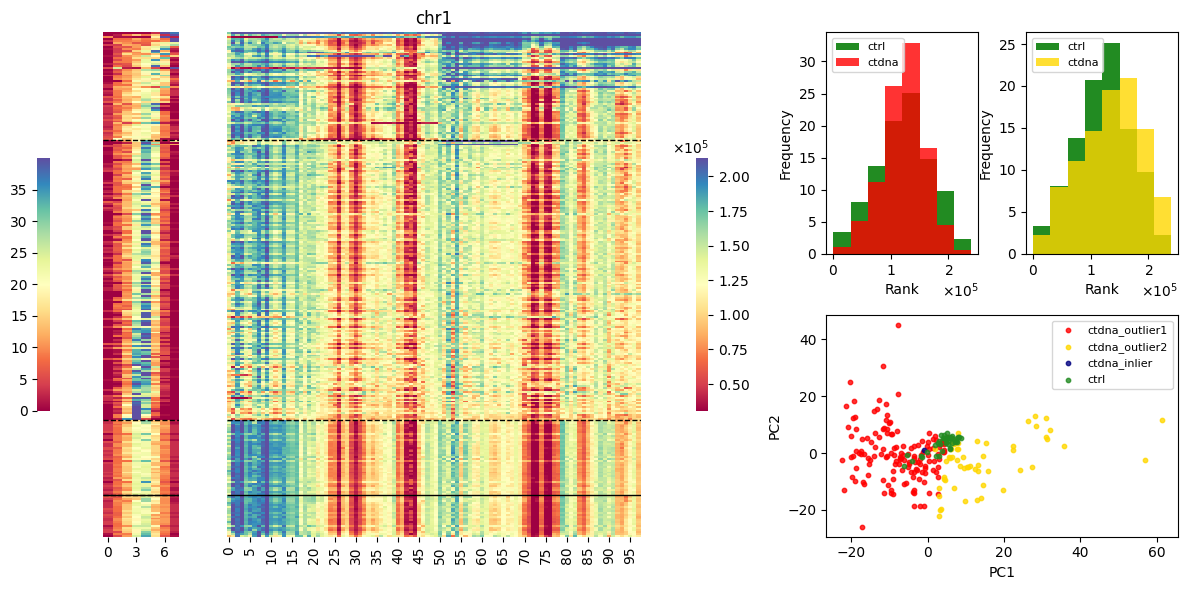

In [28]:
#plot_chr_hist_vs_segments_PCA(outfig='figures/fig5.8in-histogram.nosubplot_adjust.png')
plot_chr_hist_vs_segments_PCA()